In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesflow as bf
import pandas as pd
import seaborn as sns

import pickle

INFO:bayesflow:Using backend 'tensorflow'


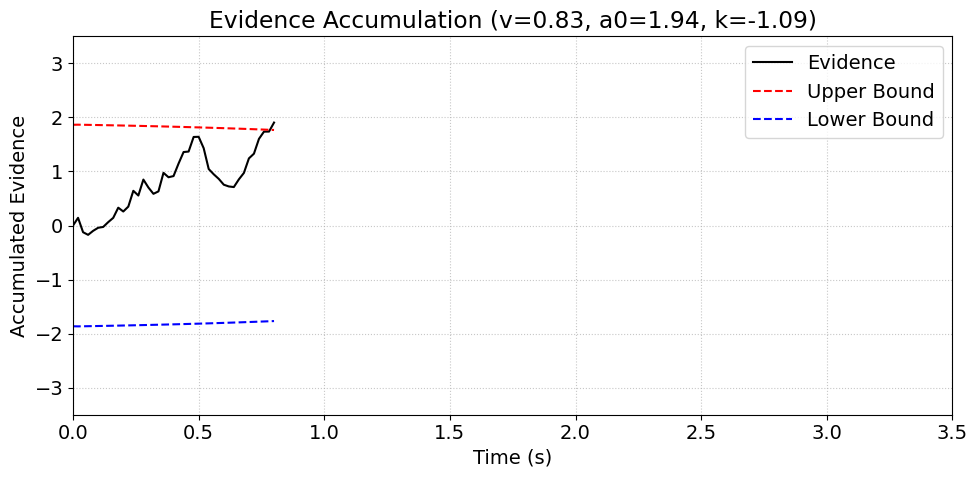

In [64]:
class DDMcollapsingBoundary:
    def __init__(self, drift, k, a0, dt=0.02, max_t=3.0):
        self.v = drift
        self.k = k
        self.a0 = a0
        self.dt = dt
        self.max_t = max_t

    def evidence_accumulation_analysis(self):
        x = 0
        steps = int(self.max_t / self.dt)
        trajectory = [x]
        boundary = [self.a0 * (1 - np.exp(self.k * (3 - self.dt)))]
        for i in range(steps):
            t = i * self.dt
            a_t = self.a0 * (1 - np.exp(self.k * (3 - t)))
            boundary.append(a_t)
            dx = self.v * self.dt + np.sqrt(self.dt) * np.random.randn()
            x += dx
            trajectory.append(x)
            if x >= a_t:
                return t, 1, trajectory, boundary
            elif x <= -a_t:
                return t, 0, trajectory, boundary
        return self.max_t, 1 if x > 0 else 0, trajectory, boundary

    def evidence_accumulation(self):
        x = 0
        steps = int(self.max_t / self.dt)
        for i in range(steps):
            t = i * self.dt
            a_t = self.a0 * (1 - np.exp(self.k * (self.max_t - t)))
            dx = self.v * self.dt + np.sqrt(self.dt) * np.random.randn()
            x += dx
            if x >= a_t:
                return t, 1
            elif x <= -a_t:
                return t, 0
        return self.max_t, 1 if x > 0 else 0

model = DDMcollapsingBoundary(5*np.random.normal(0.5, 0.5), -1 - 0.1*np.random.gamma(2, 0.5), 1.85 + 0.1*np.random.gamma(2, 0.5))
time, response, trajectory, boundary = model.evidence_accumulation_analysis()

times = np.arange(len(trajectory)) * model.dt

plt.figure(figsize=(10, 5))
plt.plot(times, trajectory, label="Evidence", color='black')
plt.plot(times, boundary, label="Upper Bound", color='red', linestyle='--')
plt.plot(times, [-b for b in boundary], label="Lower Bound", color='blue', linestyle='--')
plt.xlabel("Time (s)")
plt.xlim(0, 3.5)
plt.ylim(-3.5, 3.5)
plt.ylabel("Accumulated Evidence")

# Title with parameter values
plt.title(f"Evidence Accumulation (v={model.v:.2f}, a0={model.a0:.2f}, k={model.k:.2f})")

plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()



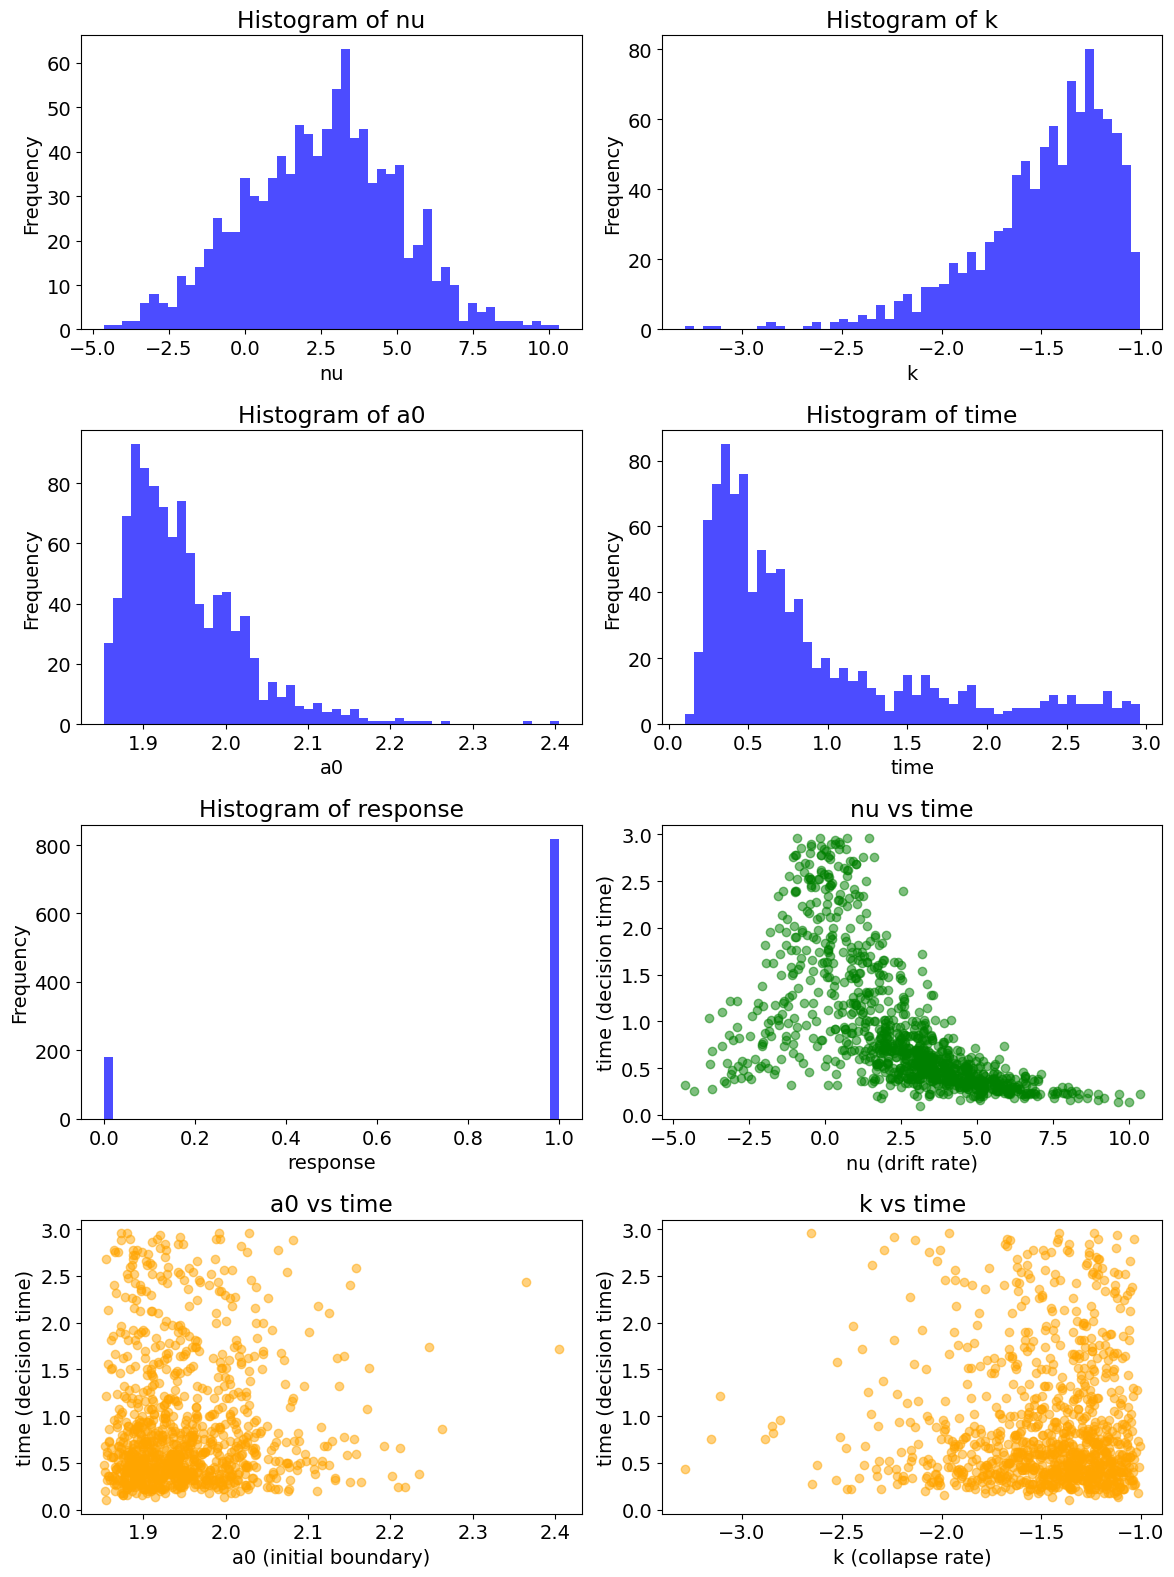

In [65]:
from scipy.stats import truncnorm

nu_list = []
k_list = []
a0_list = []
time_list = []
response_list = []

for i in range(1000):
    nu = 5*np.random.normal(0.5, 0.5)
    k = -1 - 0.5*np.random.gamma(2, 0.5)
    a0 = 1.85 + 0.1*np.random.gamma(2, 0.5)

    model = DDMcollapsingBoundary(nu, k, a0)
    time, response, trajectory, boundary = model.evidence_accumulation_analysis()

    nu_list.append(nu)
    k_list.append(k)
    a0_list.append(a0)
    time_list.append(time)
    response_list.append(response)

# Create DataFrame
df = pd.DataFrame({
    'nu': nu_list,
    'k': k_list,
    'a0': a0_list,
    'time': time_list,
    'response': response_list
})

# Plot histograms and scatter plot
columns = ['nu', 'k', 'a0', 'time', 'response']
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # 3 rows, 2 columns
axes = axes.flatten()  # Flatten axes array

# Plot histograms
for i, col in enumerate(columns):
    axes[i].hist(df[col], bins=50, color='blue', alpha=0.7)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Scatter plot: nu vs time
axes[5].scatter(df['nu'], df['time'], alpha=0.5, color='green')
axes[5].set_title("nu vs time")
axes[5].set_xlabel("nu (drift rate)")
axes[5].set_ylabel("time (decision time)")

# Scatter plot: a0 vs time
axes[6].scatter(df['a0'], df['time'], alpha=0.5, color='orange')
axes[6].set_title("a0 vs time")
axes[6].set_xlabel("a0 (initial boundary)")
axes[6].set_ylabel("time (decision time)")

# Scatter plot: k vs time
axes[7].scatter(df['k'], df['time'], alpha=0.5, color='orange')
axes[7].set_title("k vs time")
axes[7].set_xlabel("k (collapse rate)")
axes[7].set_ylabel("time (decision time)")

plt.tight_layout()
plt.show()

In [66]:
def context(n=None):
    if n is None:
        n = 200
    return dict(n=n)

def prior(nu=None, k=None):
    nu = 5*np.random.normal(0.5, 0.5)
    k = -1 - 0.5*np.random.gamma(2, 0.5)
    a0 = 1.85 + 0.1*np.random.gamma(2, 0.5)

    return dict(nu=nu, k=k, a0=a0)

def simulate_ddm_trial(v, k, a0):
    model = DDMcollapsingBoundary(v, k, a0)
    return model.evidence_accumulation()

def likelihood(nu, k, a0, n = 200, max_n=200):
    rt = np.zeros(max_n)
    response = np.zeros(max_n)
    for i in range(n):
        result = simulate_ddm_trial(nu, k, a0)
        rt[i] = result[0]
        response[i] = result[1]
    return dict(rt=rt, acc=response)

simulator = bf.make_simulator([context, prior, likelihood])

simulator.sample(1)

{'n': array([[200]]),
 'nu': array([[1.38333158]]),
 'k': array([[-1.15096737]]),
 'a0': array([[2.08438562]]),
 'rt': array([[1.52, 0.6 , 1.5 , 0.86, 1.02, 0.46, 0.96, 1.08, 0.64, 1.22, 2.22,
         0.62, 1.02, 2.02, 1.82, 0.58, 0.52, 1.28, 1.  , 1.94, 0.44, 1.12,
         0.8 , 0.88, 1.82, 0.54, 1.44, 1.06, 0.84, 1.26, 1.94, 0.74, 2.74,
         1.44, 1.28, 2.62, 0.6 , 1.24, 0.56, 0.46, 1.12, 2.04, 1.86, 0.52,
         0.92, 1.46, 0.66, 0.54, 1.86, 1.24, 1.18, 1.64, 1.42, 1.24, 0.9 ,
         0.62, 1.44, 0.78, 1.2 , 0.84, 1.96, 1.92, 2.14, 1.24, 1.32, 1.08,
         1.44, 1.72, 1.22, 0.74, 1.  , 1.22, 1.64, 1.9 , 0.44, 1.38, 1.26,
         1.48, 0.76, 1.48, 1.68, 0.72, 0.74, 0.72, 1.04, 1.06, 1.32, 1.42,
         1.68, 1.76, 0.42, 0.86, 1.66, 0.6 , 1.54, 0.78, 1.34, 1.1 , 0.82,
         1.42, 0.98, 1.6 , 0.54, 1.38, 1.18, 2.3 , 1.9 , 1.48, 1.3 , 1.2 ,
         1.24, 1.1 , 1.06, 1.26, 2.04, 1.84, 1.36, 1.  , 1.62, 0.58, 0.72,
         1.68, 2.32, 2.22, 0.6 , 0.84, 1.46, 0.64, 1.14, 

In [67]:
adapter = (bf.Adapter()
    .as_set(["rt","acc"])
    .standardize(include="nu")
    .standardize(include="k")
    .standardize(include="a0")
    .standardize(include="rt")
    .concatenate(["nu", "k", "a0"], into="inference_variables")
    .concatenate(["rt", "acc"], into="summary_variables")
)

workflow = bf.BasicWorkflow(
    simulator = simulator,
    adapter = adapter,
    inference_network = bf.networks.FlowMatching(
        depth=8,
        subnet_kwargs=dict(dropout=False)
    ),
    summary_network = bf.networks.DeepSet(
        depth=8,
        base_distribution="normal",
        dropout=False
    ),
    initial_learning_rate = 1e-3,
    inference_variables = ["nu", "k", "a0"],
    summary_variables = ["rt", "acc"]
)

In [68]:
train_data = simulator.sample(5000)
validation_data = simulator.sample(100)
test_data = simulator.sample(500)

In [69]:
history=workflow.fit_offline(
    data=train_data, 
    epochs=50, 
    batch_size=100, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
/Users/anirudhparameswaran/Desktop/BayesFlow/bayesflow-env/lib/python3.11/site-packages/bayesflow/adapters/transforms/standardize.py:74: FutureWarning: Dynamic standardization is deprecated and will be removed in later versions.Instead, use the standardize argument of the approximator / workflow instance or provide fixed mean and std arguments. You may incur some redundant computations if you keep this transform.
  warnings.warn(


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 242.3121 - loss/inference_loss: 239.9471 - loss/summary_loss: 2.3650 - val_loss: 9.0937 - val_loss/inference_loss: 7.1666 - val_loss/summary_loss: 1.9271
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 16.3616 - loss/inference_loss: 13.9144 - loss/summary_loss: 2.4472 - val_loss: 9.9942 - val_loss/inference_loss: 8.2029 - val_loss/summary_loss: 1.7913
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 999ms/step - loss: 9.8236 - loss/inference_loss: 7.8485 - loss/summary_loss: 1.9751 - val_loss: 5.6940 - val_loss/inference_loss: 4.0798 - val_loss/summary_loss: 1.6142
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 4.1841 - loss/inference_loss: 3.0485 - loss/summary_loss: 1.1356 - val_loss: 3.4757 - val_loss/inference_loss: 2.6982 - val_loss/summary_loss: 0.7775
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 2.9969 - loss/inference_loss: 2.1763 - loss/summary_loss: 0.8206 - val_loss: 2.5644 - val_loss/infere

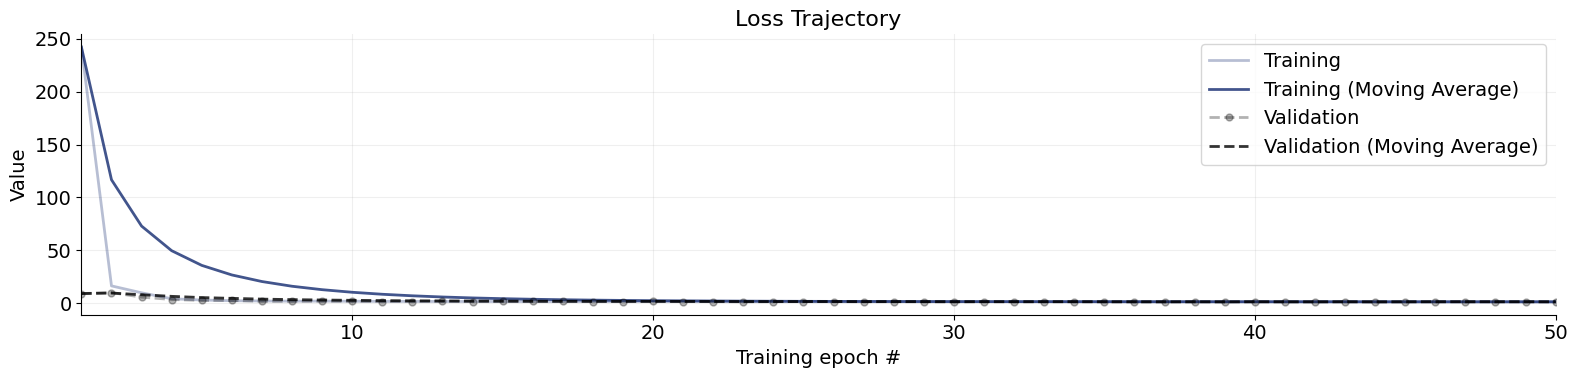

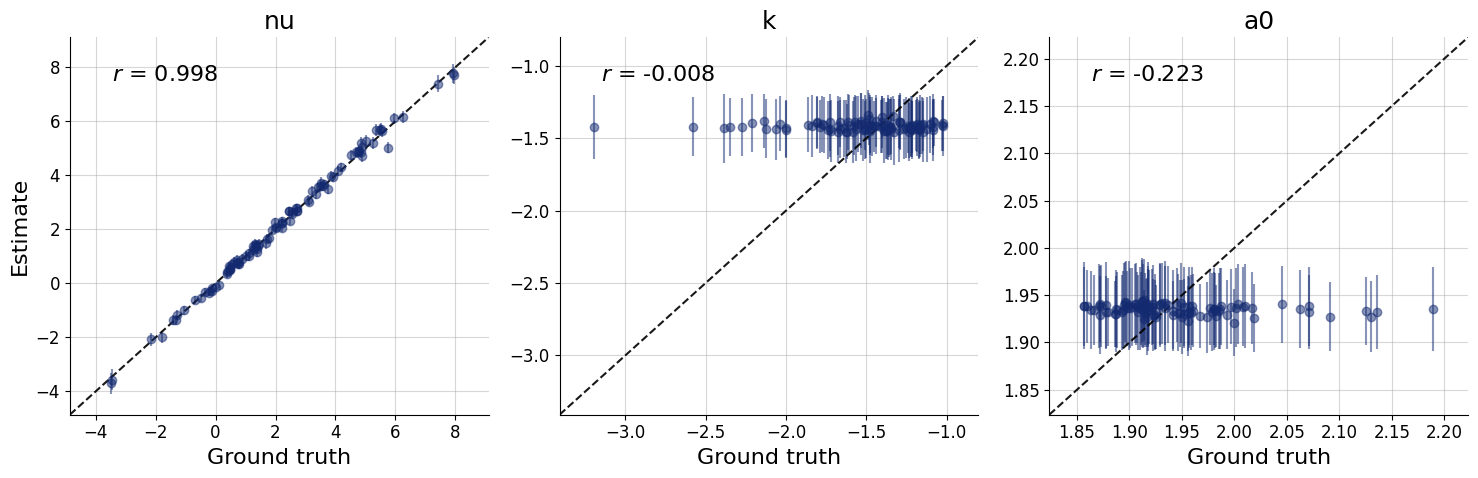

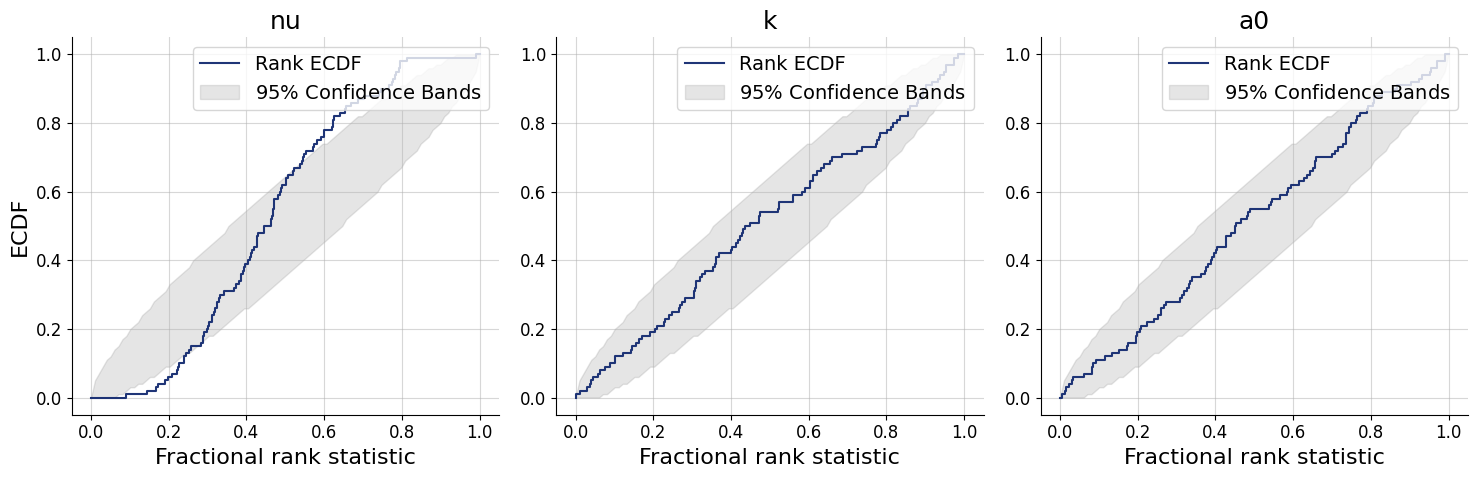

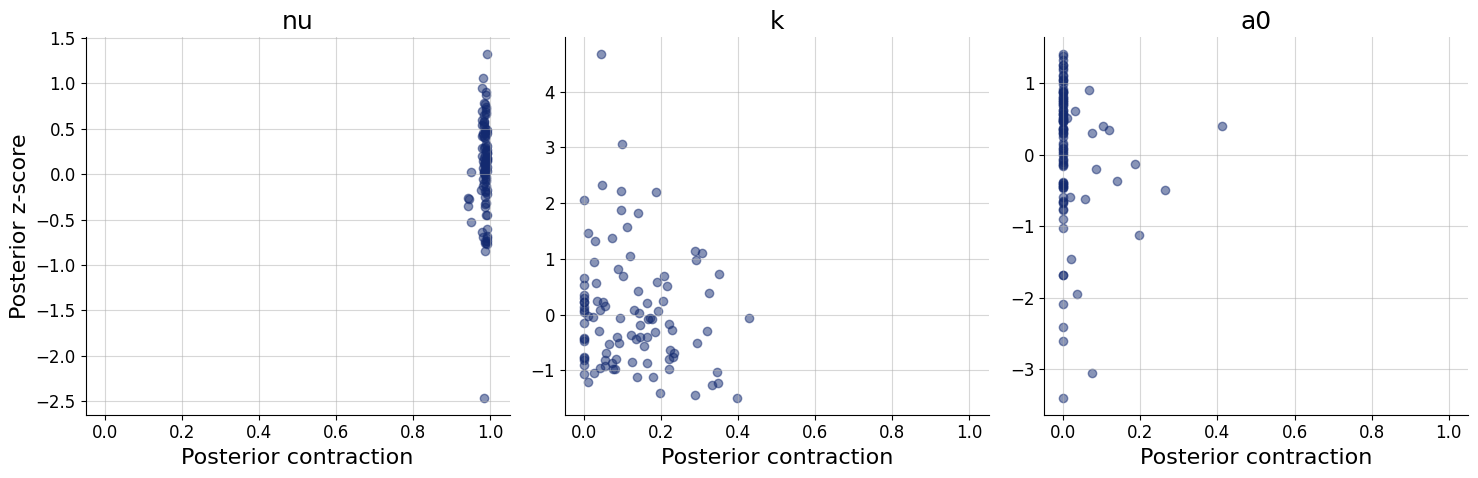

In [70]:
plots=workflow.plot_default_diagnostics(test_data=simulator.sample(100))

In [71]:
import pyreadr
exp1 = pyreadr.read_r('experiment-1-RDM.Rdata')

first_key = list(exp1.keys())[0]
df1 = exp1[first_key]
df1.head()

,coherence,rt,acc,pp,deadline,cue
0,0.03,1.009977,1,0,Deadline,AC
1,0.03,0.826265,0,0,Deadline,AC
2,0.03,1.159891,1,0,Deadline,AC
3,0.03,0.726720,1,0,Deadline,AC
4,0.03,0.709906,1,0,Deadline,AC


In [72]:
df1['condition'] = df1['deadline'].astype(str) + '_' + df1['cue'].astype(str)
df1.groupby('condition', as_index=False).agg({'rt':['mean','count'],'acc':'mean'})

condition        rt             acc
                       mean count      mean
0     Deadline_AC  0.563501  4732  0.844041
1     Deadline_SP  0.493483  4743  0.722328
2  No Deadline_AC  0.784126  4799  0.891436
3  No Deadline_SP  0.571741  4798  0.783451

In [73]:
TRIALS_PER_CONDITION = 800

grouped = df1.groupby('condition')
data_inference_dict = {}
for key in ['rt', 'acc']:
    stacked = []
    for _, group in grouped:
        vals = group[key].values[:TRIALS_PER_CONDITION] 
        if len(vals) < TRIALS_PER_CONDITION:
            raise ValueError(f"Group smaller than {TRIALS_PER_CONDITION} trials: {len(vals)}")
        stacked.append(vals.reshape(TRIALS_PER_CONDITION, 1))
    data_inference_dict[key] = np.array(stacked)

In [74]:
posterior_samples = workflow.sample(conditions=data_inference_dict, num_samples=500)


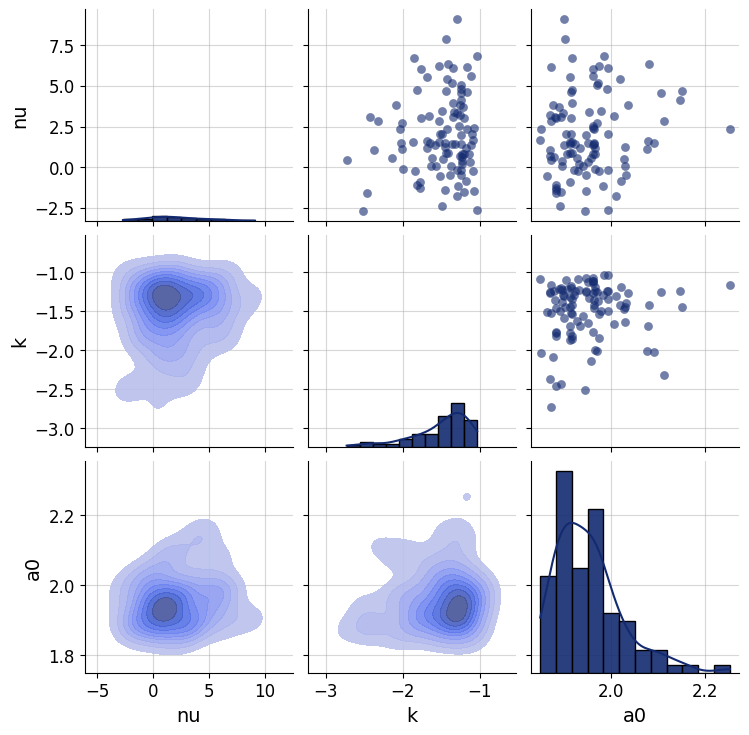

In [75]:
prior_samples = simulator.sample(100)

grid = bf.diagnostics.plots.pairs_samples(
    prior_samples, variable_keys=["nu","k","a0"]
)

In [76]:
posterior = {key: value[0] for key, value in posterior_samples.items()}

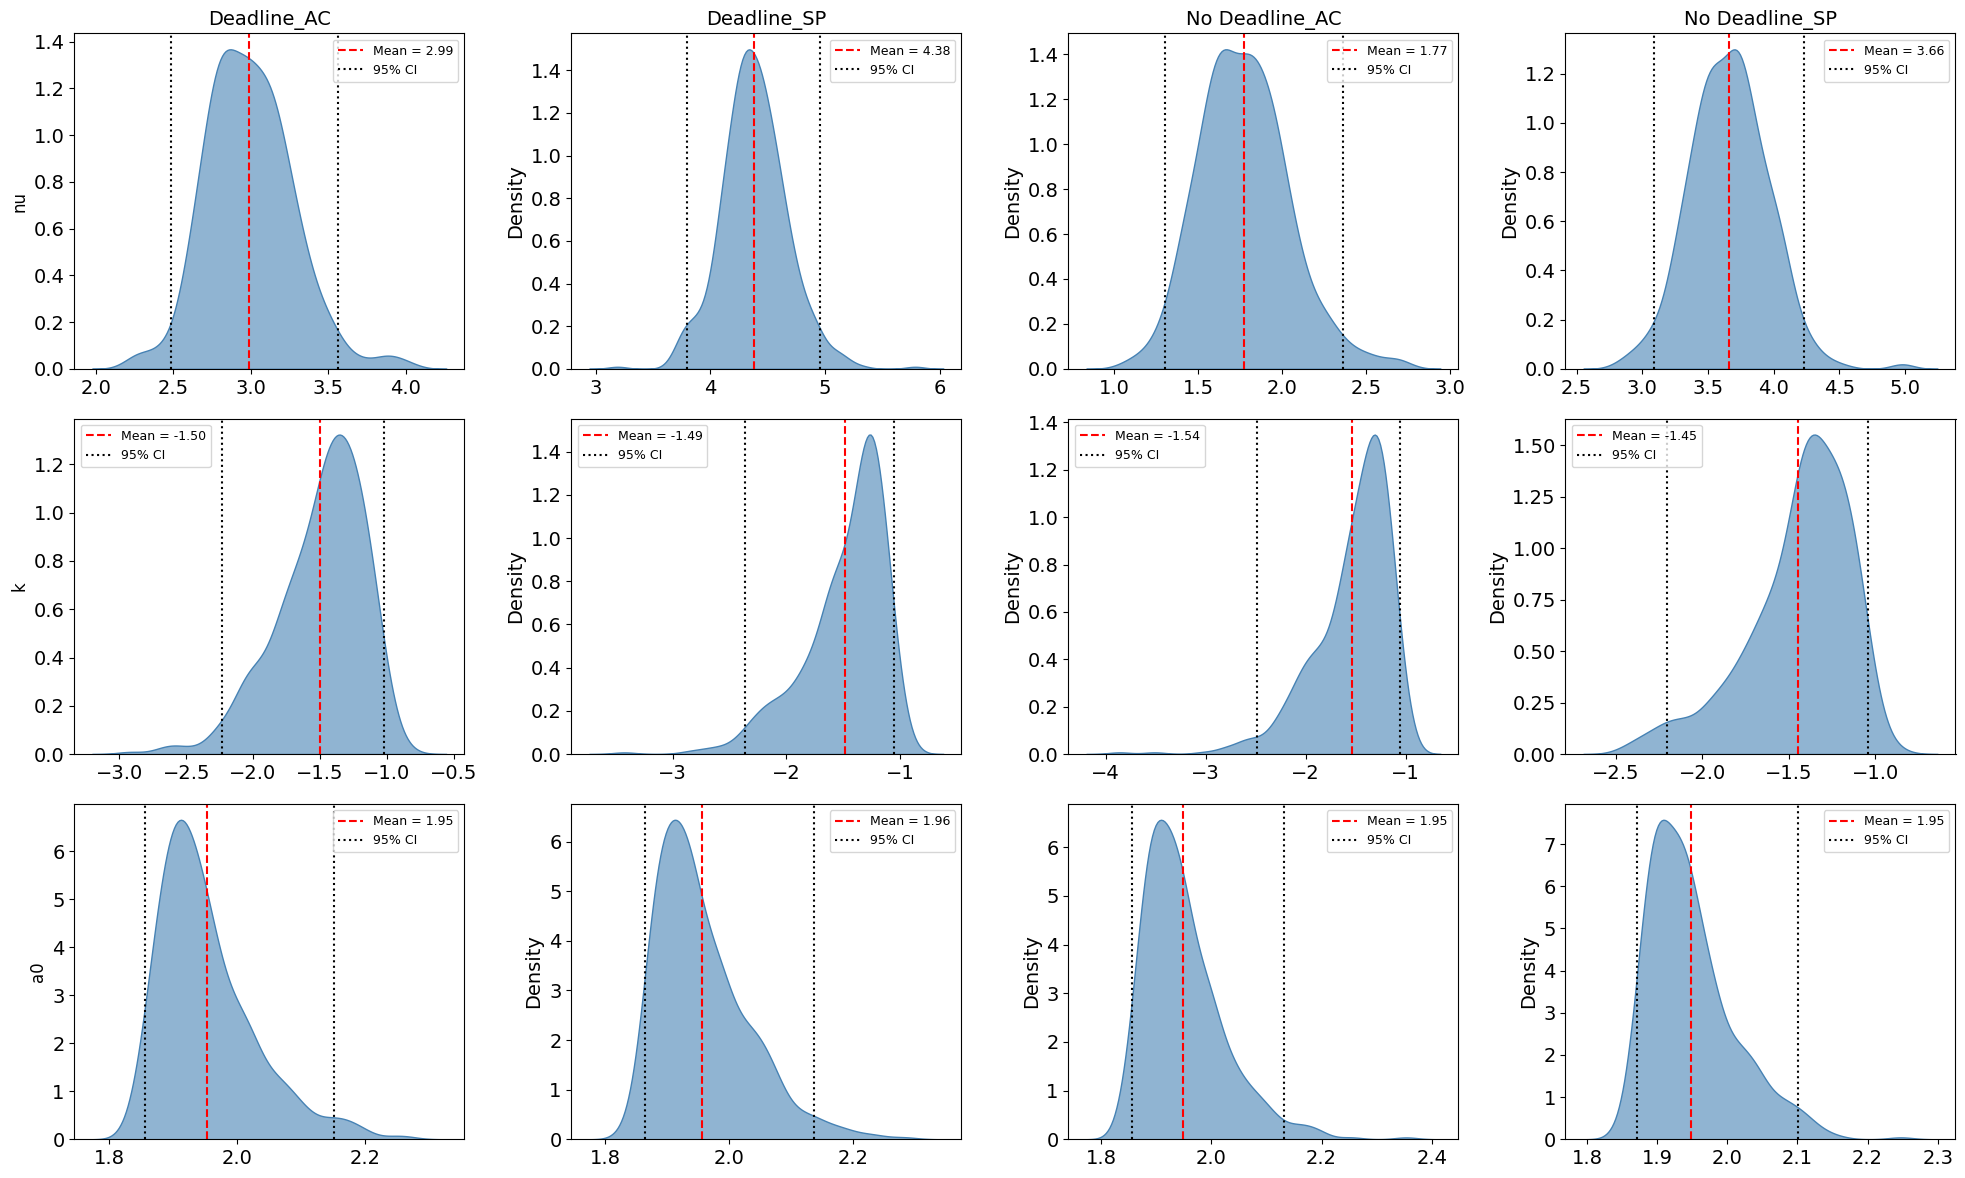

In [77]:
import seaborn as sns

param_names = ['nu', 'k', 'a0']
condition_labels = ["Deadline_AC", "Deadline_SP", "No Deadline_AC", "No Deadline_SP"]

fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharex=False, sharey=False)

for row, param in enumerate(param_names):
    for col, cond in enumerate(condition_labels):
        ax = axes[row, col]
        
        # Extract posterior samples for this param and condition
        samples = posterior_samples[param][col].squeeze()
        
        # Plot density
        sns.kdeplot(samples, ax=ax, fill=True, color="steelblue", alpha=0.6)
        
        # Add vertical lines for mean and 95% credible interval
        mean_val = samples.mean()
        ci_lower, ci_upper = np.quantile(samples, [0.025, 0.975])
        ax.axvline(mean_val, color="red", linestyle="--", label=f"Mean = {mean_val:.2f}")
        ax.axvline(ci_lower, color="black", linestyle=":", label=f"95% CI")
        ax.axvline(ci_upper, color="black", linestyle=":")
        
        # Titles and labels
        if row == 0:
            ax.set_title(cond, fontsize=14)
        if col == 0:
            ax.set_ylabel(param, fontsize=12)
        ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

In [78]:
def ppc_ddm(posterior, simulator, obs_rt, obs_resp, n_sims=200, color="#132a70", figsize=(10, 5)):
    plt.rcParams["font.size"] = 14
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    # Pick random subset of posterior draws
    idx = np.random.choice(posterior['nu'].shape[0], size=n_sims, replace=False)

    sims_rt = []
    sims_resp = []

    for i in idx:
        nu_i = float(posterior['nu'][i])
        tau_i = float(posterior['k'][i])
        a0_i = float(posterior['a0'][i])

        for j in range(len(obs_rt)):
            sim_data = simulator(nu_i, tau_i, a0_i)
            sims_rt.append(sim_data[0])
            sims_resp.append(sim_data[1])

    sims_rt = np.array(sims_rt)  # shape (n_sims, n_trials)
    sims_resp = np.array(sims_resp)  # shape (n_sims, n_trials)

    ax[0].hist(obs_rt, bins=30, color="black", alpha=0.6, label="Observed RT", density=True)
    ax[0].hist(sims_rt.flatten(), bins=30, color=color, alpha=0.5, label="Predicted RT", density = True)
    ax[0].set_title("RT Observed vs Predicted")
    ax[0].legend()

    # Accuracy PPC
    obs_acc = np.mean(obs_resp)
    pred_acc = np.mean(sims_resp)  # mean over trials per simulation

    ax[1].hist(pred_acc, bins=20, color=color, alpha=0.6, label="Predicted accuracy", density = True)
    ax[1].axvline(obs_acc, color="black", linestyle="--", label="Observed accuracy")
    ax[1].set_title("Response accuracy Observed vs Predicted")
    ax[1].legend()

    return fig

/var/folders/0g/m0pt1c8j5c5f8sj0476m6j4h0000gn/T/ipykernel_44025/11196782.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nu_i = float(posterior['nu'][i])
/var/folders/0g/m0pt1c8j5c5f8sj0476m6j4h0000gn/T/ipykernel_44025/11196782.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tau_i = float(posterior['k'][i])
/var/folders/0g/m0pt1c8j5c5f8sj0476m6j4h0000gn/T/ipykernel_44025/11196782.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a0_i = float(posterior

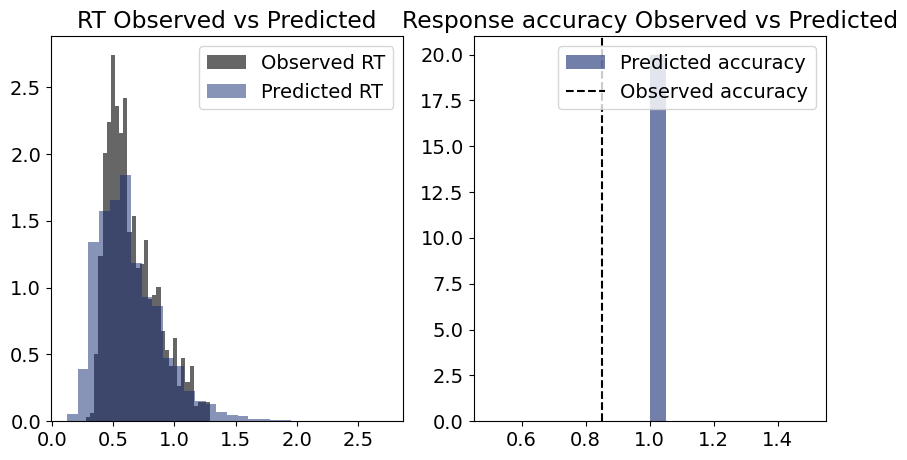

In [79]:
# Example: pick participant 0, condition 0
posterior = {k: v[0] for k, v in posterior_samples.items()}  # already shape (num_samples, n_params)

# Suppose your simulate_ddm_trial signature matches
fig = ppc_ddm(
    posterior=posterior,
    simulator=simulate_ddm_trial,
    obs_rt=deadline_ac['rt'][0:1000],
    obs_resp=deadline_ac['acc'][0:1000],
    n_sims=100
)
plt.show()